# IQPopt: Fast optimization of IQP circuits in JAX

Instantaneous Quantum Polynomial (IQP) circuits are a class of circuits that are expected to be hard to sample from using classical computers [2]. In this demo we take a look at the pacakge IQPopt [1], which shows that despite this, such circuits can still be optimized efficiently! 

As we will see, this hinges on a suprising fact about these circuits: while sampling is hard, estimating expectation values of certain observables is easy.



![IQP circuit optimization](iqpopt_main.png)

# Parameterized IQP circuits

IQP is designed to optimize a class of IQP circuits called *parameterized IQP circuits*. These are comprised of gates $\text{exp}(i\theta_j X_j)$, where the generator $X_j$ is a tensor product of Pauli X operators acting on some subset of qubits and $\theta_j$ is a trainable parameter. We will represent the parameterized gates by a list

<center><code>gates = [gen1, gen2, ...]</code></center>

that specifies the generators of the gates (each generator with an independent trainable parameter). Each element of `gates` corresponds to a different parameter, and is a list of lists of integers that specifiy the generators for that parameter. For example,

<center><code>gen1 = [[0,1]]</code></center>

specifies that the first gate has one generator which corresponds to $X\otimes X$ acting on the first two qubits of the circuit. A generator 

<center><code>gen1 = [[0,1], [0]]</code></center>

would correspond to a gate with a single parameter with generator $X\otimes X$ + $X\otimes I$. 

Here we will work with the following set of gates 

In [1]:
gates = [[[0]], [[1]], [[2]], [[0,1]], [[0,2]], [[1,2]]]

i.e., all one and two body generators acting on three qubits. 

## Expectation values

IQPopt can be applied to problems that involve measuring expectation values of Pauli Z tensors of parameterized IQP circuits. 

We will represent these observables with binary lists, where a non-zero element specifies that presence of a Pauli Z operator on that qubit. For example, for a three qubit circuit the operator

$$O = Z \otimes I \otimes Z$$

will be represented as

<center><code>op = [1,0,1]</code></center>


Let's now put this into practice and build a pennylane circuit out of a ```gates``` list.

## Creating an IQP circuit with pennylane

To build a parameterized IQP circuit in PennyLane, we can use the MultiRZ function, making use of the identity

$$\text{exp}(i\theta_j X_j) = H^{\otimes n} \text{exp}(i\theta_j Z_j) H^{\otimes n}$$

where $H$ is the Hadamard matrix and $Z_j$ is the operator obtained by replacing the Pauli X operators by Pauli Z operators in $X_j$. Our pennyalne circuit (with input state $\vert 0 \rangle$) is therefore the following.

In [2]:
import pennylane as qml
import numpy as np

def penn_iqp_gates(params: np.ndarray, gates: list, n_qubits: int):
    """IQP circuit in pennylane form.

    Args:
        params (np.ndarray): The parameters of the IQP gates.
        gates (list): The gates representation of the IQP circuit.
        n_qubits (int): The total number of qubits in the circuit.
    """

    for i in range(n_qubits):
        qml.Hadamard(i)

    for par, gate in zip(params, gates):
        for gen in gate:
            qml.MultiRZ(2*par, wires=gen)

    for i in range(n_qubits):
        qml.Hadamard(i)

Now we have our circuit, we can evaluate expectation values of tensor products of Pauli Z operators specified by lists of the form `op` above. 

In [3]:
def penn_obs(op: np.ndarray) -> qml.operation.Observable:
    """Returns a pennylane observable from a bitstring representation.

    Args:
        op (np.ndarray): Bitstring representation of the Z operator.

    Returns:
        qml.Observable: Pennylane observable.
    """
    for i, z in enumerate(op):
        if i==0:
            if z:
                obs = qml.Z(i)
            else:
                obs = qml.I(i)
        else:
            if z:
                obs @= qml.Z(i)
    return obs

def penn_iqp_circuit(params: np.ndarray, gates: list, op: np.ndarray, n_qubits: int) -> qml.measurements.ExpectationMP:
    """Defines the circuit that calculates the expectation value of the operator with the IQP circuit with pennylane tools.

    Args:
        params (np.ndarray): The parameters of the IQP gates.
        gates (list): The gates representation of the IQP circuit.
        op (np.ndarray): Bitstring representation of the Z operator.
        n_qubits (int): The total number of qubits in the circuit.

    Returns:
        qml.measurements.ExpectationMP: Pennylane circuit with an expectation value.
    """
    penn_iqp_gates(params, gates, n_qubits)
    obs = penn_obs(op)
    return qml.expval(obs)

def penn_iqp_op_expval(params: np.ndarray, gates: list, op: np.ndarray, n_qubits: int) -> float:
    """Calculates the expectation value of the operator with the IQP circuit with pennylane tools.

    Args:
        params (np.ndarray): The parameters of the IQP gates.
        gates (list): The gates representation of the IQP circuit.
        op (np.ndarray): Bitstring representation of the Z operator.
        n_qubits (int): The total number of qubits in the circuit.

    Returns:
        float: Expectation value.
    """
    dev = qml.device("lightning.qubit", wires=n_qubits)
    penn_iqp_circuit_exe = qml.QNode(penn_iqp_circuit, dev)
    return penn_iqp_circuit_exe(params, gates, op, n_qubits)

With this, we can now calculate all expectation values of Pauli Z tensors of any parameterizec IQP circuit we can think of. Let's see an example using our `gates` list from above. 

In [4]:
n_qubits = 3
op = np.array([1,0,1]) # operator ZIZ
params = np.random.rand(len(gates)) # random parameters for all the gates (remember we have 5 gates with 6 generators in total)

penn_op_expval = penn_iqp_op_expval(params, gates, op, n_qubits)
print(penn_op_expval)

0.13023257631237486


## Estimating expectation values with IQPopt

IQPopt is able to perform the same operations our pennylane circuit above is able to do. Although, this time, only with approximations instead of exact values. The gain is that we can work with very large circuits.

Starting from a paper [5] from Van den Nest (Theorem 3), one can arrive at the following expression for expectation values of Pauli Z operators

$$\langle Z_{\boldsymbol{a}} \rangle = \mathbb{E}_{\boldsymbol{z}\sim U}\Big[ \cos\Big(\sum_j \theta_{j}(-1)^{\boldsymbol{g}_{j}\cdot \boldsymbol{z}}(1-(-1)^{\boldsymbol{g}_j\cdot \boldsymbol{a}}\Big) \Big],$$

where $\boldsymbol{a}$ is the bitstring form of the operator we want to calculate the expectation value of, $\boldsymbol{z}$ are bitstring samples taken from the uniform distribution, $\theta_{j}$ are the trainable parameters and $\boldsymbol{g}_{j}$ are the different generators also in bitstring form. Although this expression is exact, computing the expectation exactly requires an infite number of samples $\boldsymbol{z}$. Instead, we can replace the expectation with an empirical mean and compute an unbiased estimate of $\langle Z_{\boldsymbol{a}} \rangle$ efficiently. That is, if we sample a batch of $s$ bitstrings $\{\boldsymbol{z}_i\}$ from the uniform distribution and compute the sample mean

$$\hat{\langle Z_{\boldsymbol{a}}\rangle} = \frac{1}{s}\sum_{i}\cos\Big(\sum_j \theta_j(-1)^{\boldsymbol{g}_j\cdot \boldsymbol{z}_i}(1-(-1)^{\boldsymbol{g}_j\cdot \boldsymbol{a}})\Big),$$

we obtain an unbiased estimate $\hat{\langle Z_{\boldsymbol{a}}\rangle}$ of $\langle Z_{\boldsymbol{a}}\rangle$; i.e. we have that $\mathbb{E}[\hat{\langle Z_{\boldsymbol{a}}\rangle}] = \langle Z_{\boldsymbol{a}}\rangle$. The error of this approximation is well known since, by the central limit theorem, the standard deviation of the sample mean of a bounded random variable decreases as $\mathcal{O}(1/\sqrt{s})$.


Let's see now how to use the IQPopt package to calculate expectation values, using the same arguments we used in the previous example. First, we create the circuit object with ```IqpSimulator``` only with the number of qubits of the circuit and the ```gates``` parameter already explained:

In [5]:
import iqpopt as iqp

small_circuit = iqp.IqpSimulator(n_qubits, gates)

To obtain estimates of expectation values we use the class method ```IqpSimulator.op_expval()```. This function requires a parameter array ```params```, a PauliZ operator specified by its binary representation ```op```, a new parameter ```n_samples``` (the number of samples $s$) that controls the precision of the approximation (the more the better), and a JAX pseudo random number generator key to seed the randomness of the sampling. It returns the expectation value estimate as well as its standard error.

Using the same ```params``` and ```op``` as before:

In [6]:
import jax

n_samples = 2000
key = jax.random.PRNGKey(66)

expval, std = small_circuit.op_expval(params, op, n_samples, key)

print(expval, std)

[0.12434083] [0.01339994]


Since the calculation on ```iqpopt```'s side is stochastic, the result is not exactly the same than the one obtained with pennylane. But, as we can see, they are within std error. You can try increasing ```n_samples``` in order to obtain closer approximations.

This function also allows for fast batch evaluation of expectation values. If we specify a batch of operators ```ops``` by an array, we can batch evaluate the expectation values and errors in parallel with the same syntax.

In [7]:
ops = np.array([[1,0,0],[0,1,0],[0,0,1]]) # batch of single qubit Pauli Zs

expvals, stds = small_circuit.op_expval(params, ops, n_samples, key)

print(expvals, stds)

[-0.12944668  0.22889233  0.64510276] [0.01914976 0.01153743 0.00658739]


With pennylane it would be very time consuming to pass the 30 qubit mark, but with IQPopt, we can easily go way further than that.

In [8]:
n_qubits = 1000
n_gates = 1000

gates = []
for _ in range(n_gates):
    # First we create a generator with bodyness 2
    gen = list(np.random.choice(n_qubits, 2, replace=False))
    # Each gen will have its independent trainable parameter, so we can directly build the gate
    gates.append([gen])

large_circuit = iqp.IqpSimulator(n_qubits, gates)

params = np.random.rand(len(gates))
op = np.random.randint(0, 2, n_qubits)
n_samples = 1000
key = jax.random.PRNGKey(42)

expval, std = large_circuit.op_expval(params, op, n_samples, key)

print(expval, std)

[-0.00813489] [0.02254851]


## Sampling and probabilities

If we measure the output qubits of an IQP circuit we generate samples of binary vectors according to the distribution

$$q_{\boldsymbol{\theta}}(\boldsymbol{x}) \equiv q(\boldsymbol{x}\vert\boldsymbol{\theta})=\vert\bra{\boldsymbol{x}}U(\boldsymbol{\theta})\ket{0}\vert^2.$$

Where $U(\boldsymbol{\theta})$ is the parametrized IQP gates. For a low number of qubits, we can use Pennylane to obtain the output probabilities of the circuit as well as sample from it. Note that there is not an efficient algorithm to do these so for large numbers of qubits so PennyLane returns an error in this case.  

These functions are already implemented in the ```IqpSimulator``` object. The ```.probs()``` method works as it does in pennylane, the returned array of probabilities is in lexicographic order.

In [9]:
sample = small_circuit.sample(params, shots=1)
print(sample)

probabilities = small_circuit.probs(params)
print(probabilities)

[0 0 0]
[0.28130125 0.07305846 0.00515284 0.1388627  0.10392528 0.05937407
 0.02775169 0.31057372]


In [10]:
sample = large_circuit.sample(params, shots=1)
print(sample)

MemoryError: bad allocation

In [11]:
probabilities = large_circuit.probs(params)
print(probabilities)

MemoryError: bad allocation

As we can see, we can't sample or know the probabilities of the circuit for the large one. The only efficient approximation algorithm we have is for the calculation of expectation values. Let's see how time scales for each of the methods.

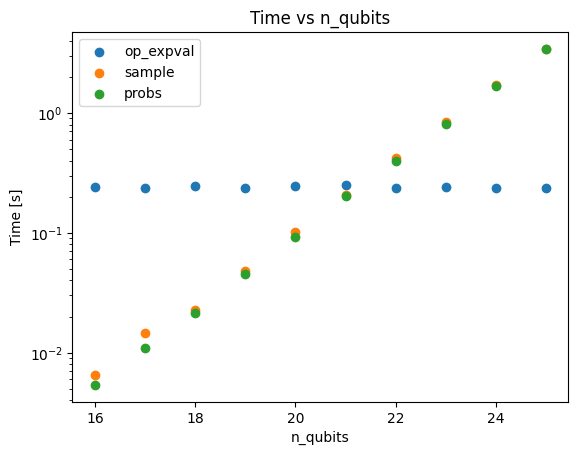

In [12]:
import time
import matplotlib.pyplot as plt

range_qubits = range(15, 26)
n_gates = 10
n_samples = 1000

times_op, times_sample, times_probs = [], [], []
for n_qubits in range_qubits:
    
    gates = []
    for _ in range(n_gates):
        gen = list(np.random.choice(n_qubits, 2, replace=False))
        gates.append([gen])
    
    circuit = iqp.IqpSimulator(n_qubits, gates)
    params_init = np.random.uniform(0, 2*np.pi, len(gates))
    key = jax.random.PRNGKey(np.random.randint(0, 99999))
    op = np.random.randint(0, 2, n_qubits)
    
    # Timing op_expval
    start = time.perf_counter()
    circuit.op_expval(params_init, op, n_samples, key)
    times_op.append(time.perf_counter() - start)
    
    # Timing sample
    start = time.perf_counter()
    circuit.sample(params_init, shots=1)
    times_sample.append(time.perf_counter() - start)
    
    # Timing probs
    start = time.perf_counter()
    circuit.probs(params_init)
    times_probs.append(time.perf_counter() - start)

plt.scatter(range_qubits[1:], times_op[1:], label="op_expval")
plt.scatter(range_qubits[1:], times_sample[1:], label="sample")
plt.scatter(range_qubits[1:], times_probs[1:], label="probs")

plt.xlabel("n_qubits")
plt.ylabel("Time [s]")
plt.yscale("log")
plt.title(f"Time vs n_qubits")
plt.legend()
plt.show()

In the previous figure, you can see that the time to sample or compute probabilities scales exponentially, however expectation values are very efficient (the scaling can be shown to be linear).

## Optimizing an IQPopt circuit

Circuits can be optimized via a separate ```Trainer``` class. To instantiate a trainer object we first define a loss function (also called an objective function), an optimizer and an initial stepsize for the gradient descent. Continuing our ```small_circuit``` example from before, below we define a simple loss function that is a sum of expectation values returned by ```.op_expval()``` .

In [13]:
import jax.numpy as jnp

def loss_fn(params, circuit, ops, n_samples, key):
    expvals = circuit.op_expval(params, ops, n_samples, key)[0]
    return jnp.sum(expvals)

optimizer = "Adam"
stepsize = 0.001

trainer = iqp.Trainer(optimizer, loss_fn, stepsize)

Any differentiable loss function expressible in JAX can be defined, but must have a first argument ```params``` that corresponds to the optimization parameters of the circuit. To minimize the loss function, we call the method ```.train()``` , which requires the number of iterations ```n_iters``` and the initial arguments of the loss function ```loss_kwargs``` given as a dictionary object. This dictionary must contain a key ```params``` whose corresponding value specifies the initial parameters.

Training Progress: 100%|██████████| 1000/1000 [00:00<00:00, 2300.10it/s, loss=-2.984846, elapsed time=0.01, total time=0.86]

Training has not converged after 1000 steps


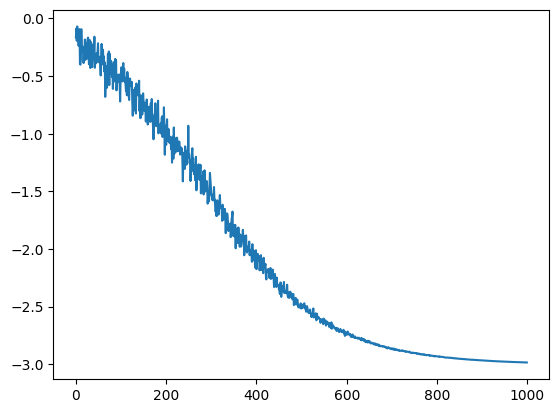

In [14]:
np.random.seed(0)

n_iters = 1000
params_init = np.random.normal(0, 1, len(small_circuit.gates))
n_samples = 100

loss_kwargs = {
    "params": params_init,
    "circuit": small_circuit,
    "ops": ops,
    "n_samples": n_samples,
    "key": key
}

trainer.train(n_iters, loss_kwargs, turbo=100) # the turbo option trains in iteration batches of the number that you input, using jit and lax.scan

trained_params = trainer.final_params
plt.plot(trainer.losses) # plot the loss curve
plt.show()

This training process finds its global minimum at loss = -3.0, which is the minimum possible with the defined loss function.

## Generative machine learning tools

The package contains a dedicated module ```gen_qml``` with functionality to train and evaluate generative models expressed as ```IqpSimulator``` circuits. Note that since sampling from IQP circuits is hard, these circuits may lead to advantages for generative machine learning tasks relative to classical models!

### Training via the maximum mean discrepancy loss

The Maximum Mean Discrepancy (MMD) [6] is an integral probability metric that measures the similarity between two probability distributions, and can serve as a loss function to train generative models.

$$ \text{MMD}^2(\boldsymbol{\theta}) = \mathbb{E}_{\boldsymbol{x},\boldsymbol{y}\sim q_{\boldsymbol{\theta}} }[k(\boldsymbol{x},\boldsymbol{y})] - 2  \mathbb{E}_{\boldsymbol{x} \sim q_{\boldsymbol{\theta}},\boldsymbol{y}\sim p }[k(\boldsymbol{x},\boldsymbol{y})] + \mathbb{E}_{\boldsymbol{x},\boldsymbol{y}\sim p }[k(\boldsymbol{x},\boldsymbol{y})] \,,$$

Using a Gaussian kernel, it has one parameter called ```sigma```, the bandwidth of this kernel. This metric is usually calculated with samples from both probability distributions and we have an implementation ready for this case in the ```gen_qml``` module.

In [18]:
import iqpopt.gen_qml as genq
from iqpopt.gen_qml.utils import median_heuristic

n_bits = 100
# toy datasets of low weight bitstrings
X1 = np.random.binomial(1, 0.05, size=(100, n_bits))
X2 = np.random.binomial(1, 0.07, size=(100, n_bits))

sigma = median_heuristic(X1) # bandwidth for MMD

mmd = genq.mmd_loss_samples(X1, X2, sigma)
print(mmd)

0.005241733930102632


This metric can also be estimated efficiently with expectation values of PauliZ operators only [7]. This means that if we have an ```IqpSimulator``` object, we can also estiamte the MMD loss. 

The implementation in the ```gen_qml``` module only needs an additional parameter, ```n_ops```, that controls the accuracy of this value. For each of these ```n_ops```, an expectation value will be calculated with ```n_samples```. The higher the number of operators and samples, the better the precision.

Let's see it in an example with 20 qubits:

In [19]:
n_qubits = 20
n_gates = 200

# toy dataset of low weight bitstrings (from ground truth p)
ground_truth = np.random.binomial(1, 0.2, size=(100, n_qubits))

gates = []
for _ in range(n_gates):
    gen = list(np.random.choice(n_qubits, 2, replace=False)) # generators with bodyness 2
    gates.append([gen])
    
circuit = iqp.IqpSimulator(n_qubits, gates)

params = np.random.normal(0, 1/np.sqrt(n_qubits), len(gates))
sigma = median_heuristic(ground_truth)/3 # bandwidth for MMD

print(sigma)

mmd = genq.mmd_loss_iqp(params,
                       circuit,
                       ground_truth,
                       sigma,
                       n_ops=1000,
                       n_samples=1000,
                       key=jax.random.PRNGKey(42))
print(mmd)

0.8164965809277259
0.022868065256672523


Now, similar to what we did a few sections back in *Optimizing a circuit*, this function can be used with a ```Trainer``` object to train a quantum generative model given as a parameterized IQP circuit.

Using the last defined 20 qubits circuit:

Training Progress: 100%|██████████| 300/300 [00:04<00:00, 62.41it/s, loss=0.000100, elapsed time=0.14, total time=5.06]

Training has not converged after 300 steps


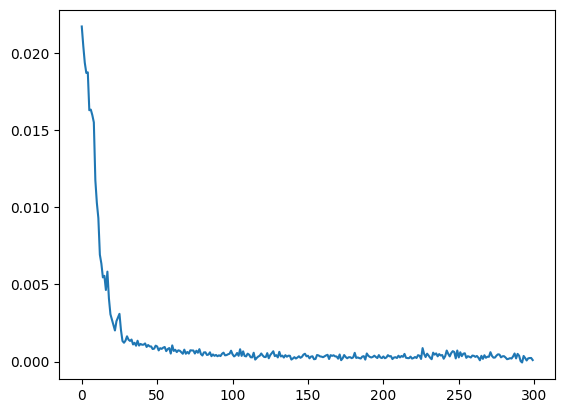

In [20]:
X_train = np.random.binomial(1, 0.2, size=(1000, n_qubits))
params_init = np.random.normal(0, 1/np.sqrt(n_qubits), len(gates))
loss = genq.mmd_loss_iqp # MMD loss

loss_kwargs = {
    "params": params_init,
    "iqp_circuit": circuit,
    "ground_truth": X_train, # samples from ground truth distribution
    "sigma": sigma,
    "n_ops": 1000,
    "n_samples": 1000,
    "key": jax.random.PRNGKey(42),
}

trainer = iqp.Trainer("Adam", loss, stepsize=0.01)
trainer.train(n_iters=300, loss_kwargs=loss_kwargs, turbo=10) 

trained_params = trainer.final_params
plt.plot(trainer.losses)
plt.show()

We can now try to see how well this generative IQP circuit resembles the ground truth. Since we are not working with a large number of qubits, we can sample from the circuit with the pennylane machinery. We can then compare our trained and untrained samples with the ground truth through a histogram of the bitstring weights and evaluate the distributions.

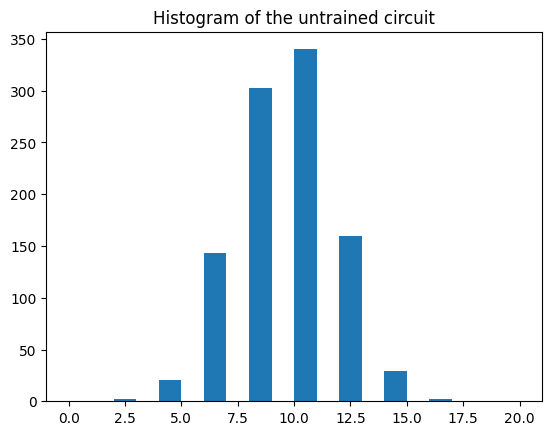

In [21]:
samples_untrained = circuit.sample(params_init, 1000)
plt.hist(np.sum(samples_untrained, axis=1), bins=20, range=[0,20])
plt.title("Histogram of the untrained circuit")
plt.show()

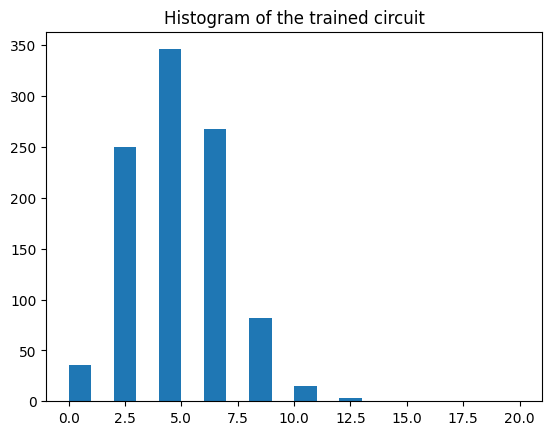

In [22]:
samples_trained = circuit.sample(trainer.final_params, 1000)
plt.hist(np.sum(samples_trained, axis=1), bins=20, range=[0,20])
plt.title("Histogram of the trained circuit")
plt.show()

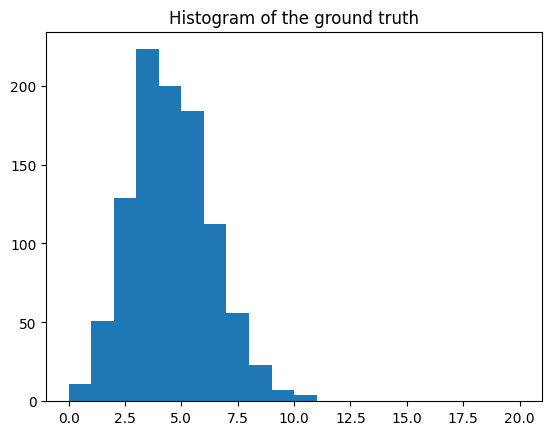

In [23]:
plt.hist(np.sum(X_train, axis=1), bins=20, range=[0,20])
plt.title("Histogram of the ground truth")
plt.show()

As we can see the trained circuit closely resembles the ground truth distribution. Although we won't cover it in this demo, the pacakge also contains tools to evaluate generative models and invtesigate model dropping via the Kernel Generalized Empirical Likelikood. 

As a final takeaway, we remark that IQPopt is perhaps the only tool for researchers analyze large circuits with potential advantages using numerical methods. By doing so, it opens up opportunities to explore systems that are too intricate for traditional pen-and-paper calculations and, as a result, it has the potential to uncover insights that were previously inaccessible.

References:

[1] Erik Recio, Joseph Bowles. "IQPopt: Fast optimization of instantaneous quantum polynomial circuits in JAX".

[2] Michael J Bremner, Richard Jozsa, and Dan J Shepherd. “Classical simulation of commuting quantum computations implies collapse of the polynomial hierarchy”. In: Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences 467.2126 (2011), pp. 459–472 (page 1).

[3] Michael J Bremner, Ashley Montanaro, and Dan J Shepherd. “Achieving quantum supremacy with sparse and noisy commuting quantum computations”. In: Quantum 1 (2017), p. 8 (page 1).

[4] Dolev Bluvstein, Simon J Evered, Alexandra A Geim, Sophie H Li, Hengyun Zhou, Tom Manovitz, Sepehr Ebadi, Madelyn Cain, Marcin Kalinowski, Dominik Hangleiter, et al. “Logical quantum processor based on reconfigurable atom arrays”. In: Nature 626.7997 (2024), pp. 58–65 (pages 1, 2).

[5] M. Van den Nest. 2Simulating quantum computers with probabilistic methods2. 2010. arXiv: 0911.1624 [quant-ph]. url: https://arxiv.org/abs/0911.1624 (pages 2, 5).

[6] Arthur Gretton, Karsten M. Borgwardt, Malte J. Rasch, Bernhard Schölkopf, and Alexander Smola. “A Kernel Two-Sample Test”. In: Journal of Machine Learning Research 13.25 (2012), pp. 723–773. url: http://jmlr.org/papers/v13/gretton12a.html (page 14).

[7] Erik Recio, Shahnawaz Ahmed, Joseph Bowles. "How to train a 1000 qubit quantum generative model on a laptop", in preparation

[8] Suman Ravuri, Mélanie Rey, Shakir Mohamed, Marc Peter Deisenroth, "Understanding Deep Generative Models with Generalized Empirical Likelihoods" 